<center><h1>Hong_Seungil_Final Project</h1></center>

Name: Seungil Hong
<br>
Github Username: zonna19
<br>
USC ID: 2375832093 

## (a) and (b) Data Exploration and Pre-processing
#### Referring the sample data preparation

In [1]:
import os
import os.path as op
import json
from pathlib import Path
import shutil
import logging
import numpy as np
from tqdm import tqdm
from skimage import io
import keras
import math

import tensorflow as tf

from matplotlib import pyplot as plt
import random
from PIL import Image 
from tensorflow.keras import layers, models, regularizers, callbacks
import warnings
warnings.filterwarnings('ignore')

from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import classification_report

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, ReLU, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

c:\ProgramData\Anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
# Logging configuration
logging.basicConfig(level=logging.INFO,
                    datefmt='%H:%M:%S',
                    format='%(asctime)s | %(levelname)-5s | %(module)-15s | %(message)s')

IMAGE_SIZE = (299, 299)  # All images contained in this dataset are 299x299 (originally, to match Inception v3 input size)
SEED = 17

# Head directory containing all image subframes. Update with the relative path of your data directory
data_head_dir = Path('./data')

# Find all subframe directories
subdirs = [Path(subdir.stem) for subdir in data_head_dir.iterdir() if subdir.is_dir()]
src_image_ids = ['_'.join(a_path.name.split('_')[:3]) for a_path in subdirs]

> Data Splits

In [3]:
# Load train/val/test subframe IDs
def load_text_ids(file_path):
    """Simple helper to load all lines from a text file"""
    with open(file_path, 'r') as f:
        lines = [line.strip() for line in f.readlines()]
    return lines

# Load the subframe names for the three data subsets
train_ids = load_text_ids('./train_source_images.txt')
validate_ids = load_text_ids('./val_source_images.txt')
test_ids = load_text_ids('./test_source_images.txt')

# Generate a list containing the dataset split for the matching subdirectory names
subdir_splits = []
for src_id in src_image_ids:
    if src_id in train_ids:
        subdir_splits.append('train')
    elif src_id in validate_ids:
        subdir_splits.append('validate')
    elif(src_id in test_ids):
        subdir_splits.append('test')
    else:
        logging.warning(f'{src_id}: Did not find designated split in train/validate/test list.')
        subdir_splits.append(None)

## (b) Data Exploration and Pre-processing, Loading and pre processing the data
##### Note that there are multiple ways to preprocess and load your data in order to train your model in tensorflow. We have provided one way to do it in the following cell. Feel free to use your own method and get better results.

In [12]:
def load_and_preprocess(img_loc, label):
    def _inner_function(img_loc, label):
        # Convert tensor to native type
        img_loc_str = img_loc.numpy().decode('utf-8')
        
        # Load image using PIL and convert to RGB
        img = Image.open(img_loc_str).convert('RGB')
        
        # Convert PIL image to numpy array
        img = np.array(img)
        
        # Normalize the image to the [0, 1] range
        img = img / 255.0

        # Convert label to integer (assuming binary classification)
        label = 1 if label.numpy().decode('utf-8') == 'frost' else 0
        
        return img, label

    # Wrap the Python function
    X, y = tf.py_function(_inner_function, [img_loc, label], [tf.float32, tf.int64])
    
    # Set the shape of the tensors
    X.set_shape([299, 299, 3])
    y.set_shape([])  # Scalar label
    
    return X, y

def load_subdir_data(dir_path, image_size, seed=None):
    
    """Helper to create a TF dataset from each image subdirectory"""
    
    # Grab only the classes that (1) we want to keep and (2) exist in this directory
    tile_dir = dir_path / Path('tiles')
    label_dir = dir_path /Path('labels')
    
    loc_list = []
    
    for folder in os.listdir(tile_dir):
        if os.path.isdir(os.path.join(tile_dir, folder)):
            for file in os.listdir(os.path.join(tile_dir, folder)):
                if file.endswith(".png"):
                    loc_list.append((os.path.join(os.path.join(tile_dir, folder), file), folder))

    return loc_list

# Loop over all subframes, loading each into a list
tf_data_train, tf_data_test, tf_data_val = [], [], []
tf_dataset_train_raw, tf_dataset_test, tf_dataset_val = [], [], []

# Update the batch and buffer size as per your model requirements
buffer_size = 64
batch_size = 32

for subdir, split in zip(subdirs, subdir_splits):
    full_path = data_head_dir / subdir
    if split=='validate':
        tf_data_val.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))
    elif split=='train':
        tf_data_train.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))
    elif split=='test':
        tf_data_test.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))
        
random.shuffle(tf_data_train)
img_list, label_list = zip(*tf_data_train)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_train_raw = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_train_raw = tf_dataset_train_raw.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_train_raw = tf_dataset_train_raw.shuffle(buffer_size=buffer_size).batch(batch_size) 

random.shuffle(tf_data_val)
img_list, label_list = zip(*tf_data_val)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_val = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_val = tf_dataset_val.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_val = tf_dataset_val.shuffle(buffer_size=buffer_size).batch(batch_size) 

random.shuffle(tf_data_test)
img_list, label_list = zip(*tf_data_test)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_test = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_test = tf_dataset_test.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_test = tf_dataset_test.shuffle(buffer_size=buffer_size).batch(batch_size) 

### ------

## (c) Training CNN + MLP

> perform empirical regularization, crop, randomly zoom, rotate, flip, contrast, and translate images in your training set for image augmentation. You can use various tools to do this, including OpenCV

In [7]:
'''! pip install tensorflow_addons'''

'! pip install tensorflow_addons'

##### i. Augmentation

In [13]:
import tensorflow_addons as tfa

def augment(image, label):
    # Randomly change brightness
    image = tf.image.random_brightness(image, max_delta=0.1)
    # Randomly change contrast
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    # Randomly rotate the image
    angle = tf.random.uniform([], minval=-math.pi/4, maxval=math.pi/4)  # Random angle in [-45, 45] degrees
    image = tfa.image.rotate(image, angle)

    # We do not need to flip images since those NASA generated images can be very rarely fliped.
    # Means assuming there are no artificial ones.
    # And Mars cannot be flimed with fliped images  

    return image, label

# Apply the augment function to each element in the dataset
tf_dataset_train = tf_dataset_train_raw.map(augment, num_parallel_calls=tf.data.experimental.AUTOTUNE)

### ii. Train CNN + MLP

>  train a three-layer CNN followed by a dense layer on the data. 
Choose the size of the kernels and depth of the layers and the number of neurons in the dense layer (MLP) on your own. 
Use ReLU’s in all of the layers. 
Use the softmax function, batch normalization and a dropout rate of 30%, L2 regularization, as well as ADAM optimizer. Use cross entropy loss. 
Train for at least 20 epochs and perform early stopping using the validation set.
Keep the network parameters that have the lowest validation error. 
Plot the training and validation errors vs. epochs.

In [14]:
# Define the model
model = Sequential([
    # 1
    Conv2D(32, (3, 3), padding='same', input_shape=(299, 299, 3), kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    ReLU(),
    MaxPooling2D(pool_size=(2, 2)),
    
    # 2
    Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    ReLU(),
    MaxPooling2D(pool_size=(2, 2)),

    # 3 
    Conv2D(128, (3, 3), padding='same', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    ReLU(),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    Dense(2, activation='softmax')  # for binary classification with softmax
])

In [15]:
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Early stopping and model checkpointing
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

history = model.fit(
    tf_dataset_train,
    epochs=20,
    validation_data=tf_dataset_val,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/20
928/928 [==============================] - 1115s 1s/step - loss: 2.0225 - accuracy: 0.5888 - val_loss: 1.3524 - val_accuracy: 0.4746
Epoch 2/20
928/928 [==============================] - 1067s 1s/step - loss: 0.7929 - accuracy: 0.6319 - val_loss: 2.0983 - val_accuracy: 0.3218
Epoch 3/20
928/928 [==============================] - 1014s 1s/step - loss: 0.7132 - accuracy: 0.6248 - val_loss: 1.0157 - val_accuracy: 0.6657
Epoch 4/20
928/928 [==============================] - 1118s 1s/step - loss: 0.6923 - accuracy: 0.6338 - val_loss: 0.6634 - val_accuracy: 0.7899
Epoch 5/20
928/928 [==============================] - 1138s 1s/step - loss: 0.6836 - accuracy: 0.6350 - val_loss: 0.6630 - val_accuracy: 0.7827
Epoch 6/20
928/928 [==============================] - 1158s 1s/step - loss: 0.6486 - accuracy: 0.6272 - val_loss: 0.6032 - val_accuracy: 0.8274
Epoch 7/20
928/928 [==============================] - 1077s 1s/step - loss: 0.6296 - accuracy: 0.6254 - val_loss: 0.6289 - val_accuracy:

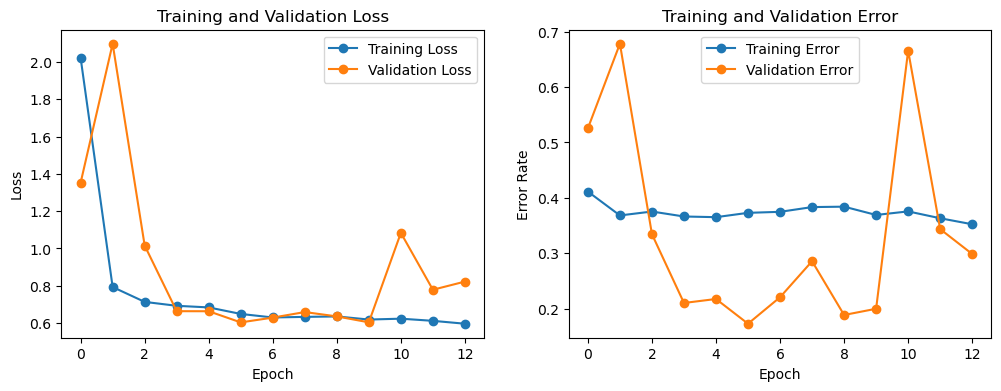

In [16]:
# Calculate error rates
train_error = [1 - acc for acc in history.history['accuracy']]
val_error = [1 - acc for acc in history.history['val_accuracy']]

# Plotting
plt.figure(figsize=(12, 4))

# Plot for Training and Validation Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss', marker='o')  # Added marker
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')  # Added marker
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot for Training and Validation Error
plt.subplot(1, 2, 2)
plt.plot(train_error, label='Training Error', marker='o')  # Plotting error
plt.plot(val_error, label='Validation Error', marker='o')  # Plotting error
plt.title('Training and Validation Error')
plt.xlabel('Epoch')
plt.ylabel('Error Rate')
plt.legend()

plt.show()

### iii. Report Precision, Recall, and F1 score for your model

In [20]:
best_model = load_model('best_model.h5')
# Predict on the test dataset
predictions = best_model.predict(tf_dataset_test)

401/401 [==============================] - 121s 301ms/step


In [19]:
predicted_labels = np.argmax(predictions, axis=1)

# Extracting True Labels from the Test Dataset
true_labels = []
for images, labels in tf_dataset_test.unbatch():
    true_labels.append(labels.numpy())

true_labels = np.array(true_labels)

predicted_labels_flat = predicted_labels.flatten()
true_labels_flat = true_labels.flatten()

report = classification_report(true_labels_flat, predicted_labels_flat)
print(report)

              precision    recall  f1-score   support

           0       0.35      0.60      0.44      4418
           1       0.66      0.40      0.50      8405

    accuracy                           0.47     12823
   macro avg       0.50      0.50      0.47     12823
weighted avg       0.55      0.47      0.48     12823



## (d) Transfer Learning

In [22]:
def load_and_preprocess_224(img_loc, label):
  """
  Loads and preprocesses an image and its label.

  Args:
    img_loc: The location of the image file as a tf.string tensor.
    label: The label of the image as a tf.string tensor.

  Returns:
    A tuple of the preprocessed image (tf.float32) and the label (tf.int64).
  """

  def _inner_function_224(img_loc, label):
    """Inner function that performs the preprocessing."""
    # Convert tensor to native type
    img_loc_str = img_loc.numpy().decode('utf-8')

    # Load image using PIL and convert to RGB
    img = Image.open(img_loc_str).convert('RGB')

    # Resize the image to the desired size (224x224)
    img = img.resize((224, 224), Image.ANTIALIAS)

    # Convert PIL image to numpy array
    img = np.array(img)

    # Normalize the image to the [0, 1] range
    img = img / 255.0

    # Convert label to integer (assuming binary classification)
    label = 1 if label.numpy().decode('utf-8') == 'frost' else 0

    return img, label

  # Wrap the Python function
  X, y = tf.py_function(_inner_function_224, [img_loc, label], [tf.float32, tf.int64])

  # Set the shape of the tensors
  X.set_shape([224, 224, 3])  # Specify the new image size
  y.set_shape([])  # Scalar label

  return X, y

IMAGE_SIZE = (224, 224) # For those Pre-trained models

# Loop over all subframes, loading each into a list
tf_data_train, tf_data_test, tf_data_val = [], [], []
tf_dataset_train_raw, tf_dataset_test, tf_dataset_val = [], [], []

# Update the batch and buffer size as per your model requirements
buffer_size = 64
batch_size = 5 # By problem states

for subdir, split in zip(subdirs, subdir_splits):
    full_path = data_head_dir / subdir
    if split=='validate':
        tf_data_val.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))
    elif split=='train':
        tf_data_train.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))
    elif split=='test':
        tf_data_test.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))
        
random.shuffle(tf_data_train)
img_list, label_list = zip(*tf_data_train)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_train_raw = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_train_raw = tf_dataset_train_raw.map(load_and_preprocess_224, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_train_raw = tf_dataset_train_raw.shuffle(buffer_size=buffer_size).batch(batch_size) 

random.shuffle(tf_data_val)
img_list, label_list = zip(*tf_data_val)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_val = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_val = tf_dataset_val.map(load_and_preprocess_224, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_val = tf_dataset_val.shuffle(buffer_size=buffer_size).batch(batch_size) 

random.shuffle(tf_data_test)
img_list, label_list = zip(*tf_data_test)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_test = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_test = tf_dataset_test.map(load_and_preprocess_224, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_test = tf_dataset_test.shuffle(buffer_size=buffer_size).batch(batch_size) 

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout, Activation
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

### EfficientNetB0

In [24]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input

#### i. Pre-trained Model extraction

In [25]:
# Load EfficientNetB0 with pre-trained ImageNet weights
eff_base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
eff_base_model.trainable = False  # Freeze the model

#### ii. Data agumentation

In [26]:
# Apply the augment function to each element in the dataset
tf_dataset_train = tf_dataset_train_raw.map(augment, num_parallel_calls=tf.data.experimental.AUTOTUNE)

#### iii. Last layer

In [27]:
efnet_model = Sequential([
    eff_base_model,
    GlobalAveragePooling2D(),
    BatchNormalization(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dense(2, activation='softmax')  # Assuming binary classification
])

#### iv. Train using the features calculated by networks (EfficientNetB0)

In [33]:
# Compile the model
efnet_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Early stopping and model checkpointing
early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model_eff.h5', monitor='val_loss', save_best_only=True)

history_eff = efnet_model.fit(
    tf_dataset_train,
    epochs=10,
    validation_data=tf_dataset_val,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/10


5936/5936 [==============================] - 702s 117ms/step - loss: 0.6796 - accuracy: 0.5864 - val_loss: 0.7700 - val_accuracy: 0.3218
Epoch 2/10
5936/5936 [==============================] - 718s 121ms/step - loss: 0.6780 - accuracy: 0.5876 - val_loss: 0.7717 - val_accuracy: 0.3218
Epoch 3/10
5936/5936 [==============================] - 704s 119ms/step - loss: 0.6778 - accuracy: 0.5878 - val_loss: 0.7711 - val_accuracy: 0.3218
Epoch 4/10
5936/5936 [==============================] - 719s 121ms/step - loss: 0.6778 - accuracy: 0.5878 - val_loss: 0.7725 - val_accuracy: 0.3218
Epoch 5/10
5936/5936 [==============================] - 658s 111ms/step - loss: 0.6778 - accuracy: 0.5878 - val_loss: 0.7728 - val_accuracy: 0.3218


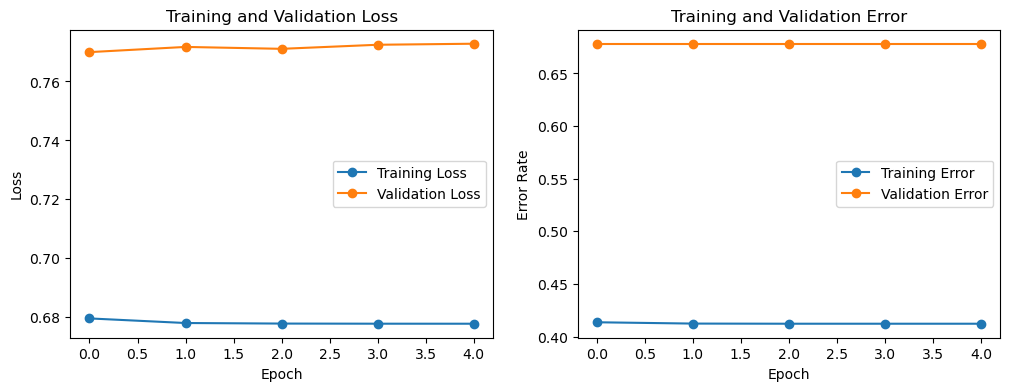

In [34]:
# Calculate error rates
train_error = [1 - acc for acc in history_eff.history['accuracy']]
val_error = [1 - acc for acc in history_eff.history['val_accuracy']]

# Plotting
plt.figure(figsize=(12, 4))

# Plot for Training and Validation Loss
plt.subplot(1, 2, 1)
plt.plot(history_eff.history['loss'], label='Training Loss', marker='o')  # Added marker
plt.plot(history_eff.history['val_loss'], label='Validation Loss', marker='o')  # Added marker
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot for Training and Validation Error
plt.subplot(1, 2, 2)
plt.plot(train_error, label='Training Error', marker='o')  # Plotting error
plt.plot(val_error, label='Validation Error', marker='o')  # Plotting error
plt.title('Training and Validation Error')
plt.xlabel('Epoch')
plt.ylabel('Error Rate')
plt.legend()

plt.show()

#### v. Report Precision, Recall, and F1 score for your model.

In [35]:
best_model_eff = load_model('best_model_eff.h5')
# Predict on the test dataset
predictions = best_model_eff.predict(tf_dataset_test)
predicted_labels = np.argmax(predictions, axis=1)

2565/2565 [==============================] - 204s 79ms/step


In [36]:
# Extracting True Labels from the Test Dataset
true_labels = []
for images, labels in tf_dataset_test.unbatch():
    true_labels.append(labels.numpy())

true_labels = np.array(true_labels)

predicted_labels_flat = predicted_labels.flatten()
true_labels_flat = true_labels.flatten()

report = classification_report(true_labels_flat, predicted_labels_flat)
print(report)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      4418
           1       0.66      1.00      0.79      8405

    accuracy                           0.66     12823
   macro avg       0.33      0.50      0.40     12823
weighted avg       0.43      0.66      0.52     12823



### ResNet50

#### i. Pre-trained Model extraction

> Do the same with ResNet50

In [37]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet import preprocess_input

base_model_resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model_resnet.trainable = False  # Freeze the base model

#### ii. Data is already agumentated

#### iii. Last layer

In [38]:
resnet_model = Sequential([
    base_model_resnet,
    GlobalAveragePooling2D(),
    BatchNormalization(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dense(2, activation='softmax')  # Assuming binary classification
])

#### iv. Train using the features calculated by networks

In [39]:
# Compile the model
resnet_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Early stopping and model checkpointing
early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model_res.h5', monitor='val_loss', save_best_only=True)

history_res = resnet_model.fit(
    tf_dataset_train,
    epochs=10,
    validation_data=tf_dataset_val,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/10
5936/5936 [==============================] - 1715s 288ms/step - loss: 0.5214 - accuracy: 0.7357 - val_loss: 0.8433 - val_accuracy: 0.4285
Epoch 2/10
5936/5936 [==============================] - 1623s 273ms/step - loss: 0.4876 - accuracy: 0.7589 - val_loss: 1.3697 - val_accuracy: 0.3757
Epoch 3/10
5936/5936 [==============================] - 1588s 267ms/step - loss: 0.4746 - accuracy: 0.7638 - val_loss: 1.1109 - val_accuracy: 0.3962
Epoch 4/10
5936/5936 [==============================] - 1555s 262ms/step - loss: 0.4681 - accuracy: 0.7690 - val_loss: 1.2166 - val_accuracy: 0.3534
Epoch 5/10
5936/5936 [==============================] - 1549s 261ms/step - loss: 0.4588 - accuracy: 0.7727 - val_loss: 1.4836 - val_accuracy: 0.3380


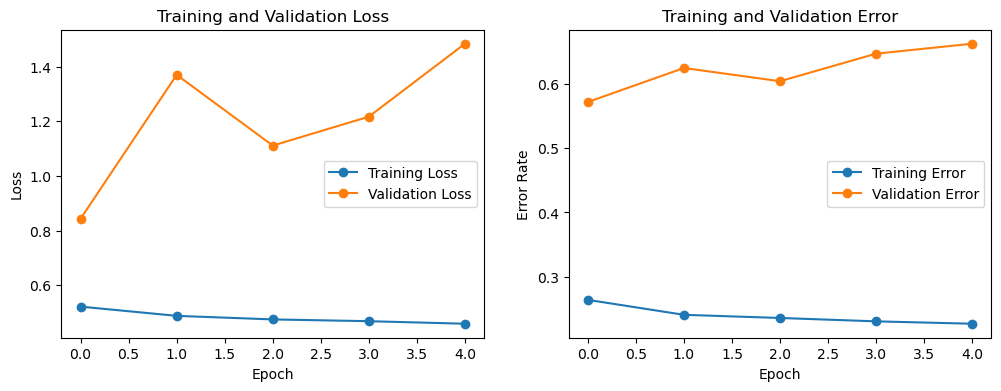

In [40]:
# Calculate error rates
train_error = [1 - acc for acc in history_res.history['accuracy']]
val_error = [1 - acc for acc in history_res.history['val_accuracy']]

# Plotting
plt.figure(figsize=(12, 4))

# Plot for Training and Validation Loss
plt.subplot(1, 2, 1)
plt.plot(history_res.history['loss'], label='Training Loss', marker='o')  # Added marker
plt.plot(history_res.history['val_loss'], label='Validation Loss', marker='o')  # Added marker
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot for Training and Validation Error
plt.subplot(1, 2, 2)
plt.plot(train_error, label='Training Error', marker='o')  # Plotting error
plt.plot(val_error, label='Validation Error', marker='o')  # Plotting error
plt.title('Training and Validation Error')
plt.xlabel('Epoch')
plt.ylabel('Error Rate')
plt.legend()

plt.show()

#### v. Report Precision, Recall, and F1 score for your model.

In [41]:
best_model_res = load_model('best_model_res.h5')
# Predict on the test dataset
predictions = best_model_res.predict(tf_dataset_test)
predicted_labels = np.argmax(predictions, axis=1)

2565/2565 [==============================] - 516s 201ms/step


In [42]:
# Extracting True Labels from the Test Dataset
true_labels = []
for images, labels in tf_dataset_test.unbatch():
    true_labels.append(labels.numpy())

true_labels = np.array(true_labels)

predicted_labels_flat = predicted_labels.flatten()
true_labels_flat = true_labels.flatten()

report = classification_report(true_labels_flat, predicted_labels_flat)
print(report)

              precision    recall  f1-score   support

           0       0.34      0.16      0.22      4418
           1       0.66      0.84      0.74      8405

    accuracy                           0.61     12823
   macro avg       0.50      0.50      0.48     12823
weighted avg       0.55      0.61      0.56     12823



### VGG16

In [43]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

#### i. Pre-trained Model extraction

In [44]:
# Initialize VGG16 as the base model for feature extraction
base_model_vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model_vgg16.trainable = False  # Freeze the base model

#### ii. Data is already agumentated

#### iii. Last layer

In [45]:
vgg_model = Sequential([
    base_model_vgg16,
    GlobalAveragePooling2D(),
    BatchNormalization(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dense(2, activation='softmax')  # Assuming binary classification
])

#### iv. Train using the features calculated by networks

In [46]:
# Compile the model
vgg_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Early stopping and model checkpointing
early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model_vgg.h5', monitor='val_loss', save_best_only=True)

history_vgg = vgg_model.fit(
    tf_dataset_train,
    epochs=10,
    validation_data=tf_dataset_val,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/10
5936/5936 [==============================] - 3899s 657ms/step - loss: 0.3948 - accuracy: 0.8179 - val_loss: 3.7041 - val_accuracy: 0.3645
Epoch 2/10
5936/5936 [==============================] - 3896s 656ms/step - loss: 0.3268 - accuracy: 0.8537 - val_loss: 4.1204 - val_accuracy: 0.3839
Epoch 3/10
5936/5936 [==============================] - 3904s 658ms/step - loss: 0.3044 - accuracy: 0.8656 - val_loss: 4.9040 - val_accuracy: 0.4193
Epoch 4/10
5936/5936 [==============================] - 3863s 651ms/step - loss: 0.2823 - accuracy: 0.8729 - val_loss: 4.1701 - val_accuracy: 0.4235
Epoch 5/10
5936/5936 [==============================] - 3999s 674ms/step - loss: 0.2808 - accuracy: 0.8768 - val_loss: 7.5733 - val_accuracy: 0.3569


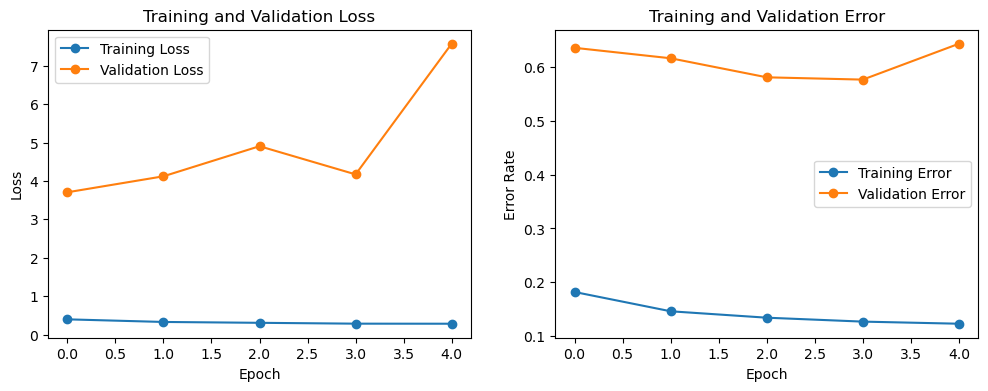

In [47]:
# Calculate error rates
train_error = [1 - acc for acc in history_vgg.history['accuracy']]
val_error = [1 - acc for acc in history_vgg.history['val_accuracy']]

# Plotting
plt.figure(figsize=(12, 4))

# Plot for Training and Validation Loss
plt.subplot(1, 2, 1)
plt.plot(history_vgg.history['loss'], label='Training Loss', marker='o')  # Added marker
plt.plot(history_vgg.history['val_loss'], label='Validation Loss', marker='o')  # Added marker
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot for Training and Validation Error
plt.subplot(1, 2, 2)
plt.plot(train_error, label='Training Error', marker='o')  # Plotting error
plt.plot(val_error, label='Validation Error', marker='o')  # Plotting error
plt.title('Training and Validation Error')
plt.xlabel('Epoch')
plt.ylabel('Error Rate')
plt.legend()

plt.show()

#### v. Report Precision, Recall, and F1 score for your model.

In [48]:
best_model_vgg = load_model('best_model_vgg.h5')
# Predict on the test dataset
predictions = best_model_vgg.predict(tf_dataset_test)
predicted_labels = np.argmax(predictions, axis=1)

2565/2565 [==============================] - 1299s 506ms/step


In [49]:
# Extracting True Labels from the Test Dataset
true_labels = []
for images, labels in tf_dataset_test.unbatch():
    true_labels.append(labels.numpy())

true_labels = np.array(true_labels)

predicted_labels_flat = predicted_labels.flatten()
true_labels_flat = true_labels.flatten()

report = classification_report(true_labels_flat, predicted_labels_flat)
print(report)

              precision    recall  f1-score   support

           0       0.33      0.08      0.13      4418
           1       0.65      0.91      0.76      8405

    accuracy                           0.63     12823
   macro avg       0.49      0.50      0.45     12823
weighted avg       0.54      0.63      0.55     12823



### iv.  Compare the results of transfer learning with those of CNN + MLP model and explain them.

> CNN+MLP's validation accuracy significantly improved during epoch processes.
CNN+MLP model actually showed it learned from each epoches whereas pre-trained model seemed not much to be improved by the last layer.

> Pre-trained models are prone to overfit or underfit excessively. Either they do high recall on Class 0 or Class 1. However ResNet did good performance among the other pre-trained models in termed of classifying Class 1 ('Frost')

> Although pre-trained models are much faster and less computationally expensive, they are not significantly better than our model using CNN + MLP, also not useful in terms of classifiying class 1 correctly. I assume those pretrained networks are made from almost every images of things in the earth. Geographical images of Mars would just whole different set of data compared from what those pretrained model used to be trained. Meanwhile accuracy was not great, The CNN+MLP model has better balanched ability to identify class 0, demonstrating a much better balance in recognizing both classes, particularly for class 0.

# (THE END)